In [1]:
import numpy as np
import scipy.special as sspec

In [2]:
def drift(x):
    return np.arctan(x)

def diff(x):
    return np.sqrt(1 + x**2)

In [3]:
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*np.abs(s)*diff(x)) 

def regf(x,s,h):
    return (np.exp(1j*s*h*drift(x) - h*np.abs(s)*diff(x)) - np.exp(-np.abs(s)*np.square(x)))

In [4]:
# set up grids of s and u values
smin = -100
smax = 100
sres = 10000
ds = (smax-smin)/sres
svec = smin + ds*np.arange(sres)
uvec = np.copy(svec)

In [5]:
# set the value of h
thish = 0.01

# set the initial condition parameters
mymean = 0.5
mysd = 0.1

# set the initial pdf
import scipy.stats as ss
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [6]:
# set up x grid for integration
Nx = 128
L = 12.8
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [7]:
# initialize kernel matrix
kernelmat = np.zeros((sres,sres),dtype='D')

for i in range(sres):
    
    # handle special Dirac delta case
    if i==(sres//2):
        kernelmat[i,i] = 1.0/ds
        continue
    
    # handle "boundary layer" near Dirac delta
    if np.abs(svec[i])<1.0:
        kernelmat[i,sres//2] = 1.0/ds
        kernelmat[i,(sres//2 + 1)] = svec[i]*0.5/(ds*ds)
        kernelmat[i,(sres//2 - 1)] = -svec[i]*0.5/(ds*ds)
        continue
    
    # compute shifted coordinate
    s = svec[i]
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        kernelmat[i,] += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    # add asymptotic corrections
    kernelmat[i,] += (1j*np.exp((1j*(thish*np.pi*svec[i] + L*k + 1j*thish*L*np.abs(svec[i])))/2.))/(k + 1j*thish*np.abs(svec[i]))
    kernelmat[i,] += (-1j*np.exp((-1j*(thish*np.pi*svec[i] + L*k - 1j*thish*L*np.abs(svec[i])))/2.))/(k - 1j*thish*np.abs(svec[i]))
    kernelmat[i,] /= 2.0*np.pi
    
    # add regularized asymptotic corrections
    # ss = np.abs(s)
    # part1 = (1j*np.exp((1j*(thish*np.pi*s + L*k + 1j*thish*L*ss))/2.))/(k + 1j*thish*ss)
    # part2 = -np.exp(-k**2/(4*ss))*np.sqrt(np.pi)*sspec.erfc((-1j*k + L*ss)/(2.0*np.sqrt(ss)))/(2.0*np.sqrt(ss))
    # kernelmat[i,] += 2.0*np.real(part1 + part2)


In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

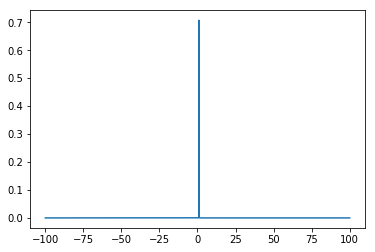

In [41]:
plt.plot(uvec, ds*np.abs(kernelmat[(sres//2+45),]))

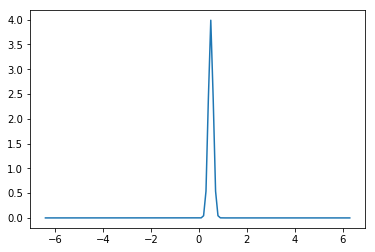

In [23]:
plt.plot(xvec, initp(xvec))

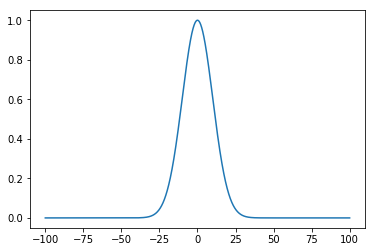

In [25]:
plt.plot(svec, np.abs(initpcf(svec)))

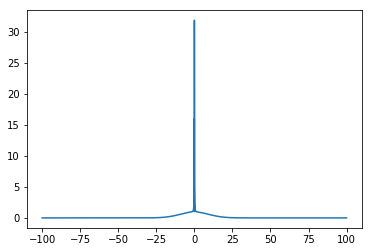

In [26]:
cf = ds*np.dot(kernelmat, initpcf(svec))
plt.plot(svec, np.abs(cf))

In [28]:
svec[sres//2+1]

0.019999999999996021

In [30]:
ds*thish

0.0002

In [43]:
svec[sres//2+50]

1.0